Using device: cuda
Training started...
Epoch [1/100] - Loss: 0.133531
Epoch [2/100] - Loss: 0.057286
Epoch [3/100] - Loss: 0.049826
Epoch [4/100] - Loss: 0.046033
Epoch [5/100] - Loss: 0.043093
Epoch [6/100] - Loss: 0.042058
Epoch [7/100] - Loss: 0.040289
Epoch [8/100] - Loss: 0.039613
Epoch [9/100] - Loss: 0.038480
Epoch [10/100] - Loss: 0.038281
Epoch [11/100] - Loss: 0.036914
Epoch [12/100] - Loss: 0.037118
Epoch [13/100] - Loss: 0.036230
Epoch [14/100] - Loss: 0.036004
Epoch [15/100] - Loss: 0.035884
Epoch [16/100] - Loss: 0.034698
Epoch [17/100] - Loss: 0.035360
Epoch [18/100] - Loss: 0.034641
Epoch [19/100] - Loss: 0.033700
Epoch [20/100] - Loss: 0.034343
Epoch [21/100] - Loss: 0.033980
Epoch [22/100] - Loss: 0.034035
Epoch [23/100] - Loss: 0.033342
Epoch [24/100] - Loss: 0.032700
Epoch [25/100] - Loss: 0.033401
Epoch [26/100] - Loss: 0.032907
Epoch [27/100] - Loss: 0.032329
Epoch [28/100] - Loss: 0.032388
Epoch [29/100] - Loss: 0.032882
Epoch [30/100] - Loss: 0.032265
Epoch [31/

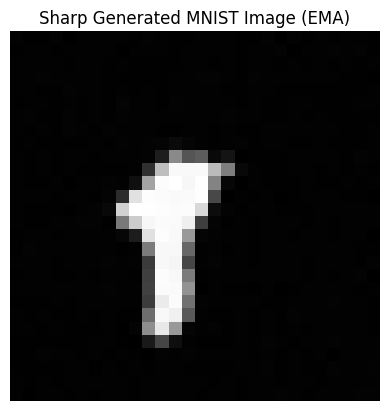

In [ ]:
# final_diffusion_with_ema.py

import math
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
batch_size = 128
T_steps = 1000        # Number of diffusion steps
epochs = 100           # Increase this if you want even sharper images
lr = 1e-4
ema_decay = 0.995     # EMA decay factor

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Sinusoidal Time Embedding
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        # time: (B,)
        device = time.device
        half_dim = self.dim // 2
        emb_factor = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb_factor)
        emb = time.float().unsqueeze(1) * emb.unsqueeze(0)  # (B, half_dim)
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)       # (B, dim)
        return emb

# A simplified UNet for diffusion with time embedding
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_emb = SinusoidalPositionEmbeddings(32)

        # Down-sampling path (encoder)
        self.down1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.GroupNorm(1, 64),
            nn.ReLU(inplace=True)
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.GroupNorm(1, 128),
            nn.ReLU(inplace=True)
        )

        # Middle block with time conditioning
        self.mid_conv = nn.Sequential(
            nn.Conv2d(128 + 32, 128, 3, padding=1),
            nn.GroupNorm(1, 128),
            nn.ReLU(inplace=True)
        )

        # Up-sampling path (decoder)
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.GroupNorm(1, 64),
            nn.ReLU(inplace=True)
        )
        self.final_conv = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x, t):
        # x: (B,1,28,28), t: (B,) (long tensor)
        # Get time embedding and reshape it
        t_emb = self.time_emb(t)  # (B, 32)

        # Encoder
        x1 = self.down1(x)      # (B,64,28,28)
        x2 = self.down2(x1)     # (B,128,14,14)

        # Expand time embedding spatially and concatenate with x2
        t_emb_expanded = t_emb.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, x2.shape[2], x2.shape[3])
        x_cat = torch.cat([x2, t_emb_expanded], dim=1)  # (B,128+32,14,14)

        # Middle
        x_mid = self.mid_conv(x_cat)  # (B,128,14,14)

        # Decoder
        x_up = self.up1(x_mid)        # (B,64,28,28)
        out = self.final_conv(x_up)   # (B,1,28,28)
        return out

# EMA class to track exponential moving averages of the model parameters
class EMA:
    def __init__(self, model, decay=0.995):
        self.decay = decay
        self.shadow = {}
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self, model):
        self.backup = {}
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]

    def restore(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]
        self.backup = {}

# Diffusion Beta schedule
betas = torch.linspace(1e-4, 0.02, T_steps).to(device)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

# Function to add noise according to the diffusion process
def add_noise(x0, t):
    noise = torch.randn_like(x0)
    sqrt_alpha_bar = alpha_bars[t].sqrt().view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar = (1 - alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
    xt = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise
    return xt, noise

# Initialize model, optimizer, loss, and EMA
model = SimpleUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
mse = nn.MSELoss()
ema = EMA(model, decay=ema_decay)

# Training Loop
print("Training started...")
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, _ in dataloader:
        images = images.to(device)
        # Sample random timesteps for each image in the batch
        t = torch.randint(0, T_steps, (images.size(0),), device=device).long()
        # Add noise based on timestep t
        xt, noise = add_noise(images, t)
        # Forward pass: predict noise
        noise_pred = model(xt, t)
        loss = mse(noise, noise_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update EMA weights after each batch
        ema.update(model)

        running_loss += loss.item()
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.6f}")

print("Training complete!")

# (Optional) Save the final model weights
os.makedirs('./models', exist_ok=True)
torch.save(model.state_dict(), './models/diffusion_mnist_unet_ema.pth')
print("Model saved at ./models/diffusion_mnist_unet_ema.pth")

# Sampling function using the EMA weights
@torch.no_grad()
def sample(model, img_size=(1, 28, 28)):
    # Use EMA weights for sampling
    ema.apply_shadow(model)
    model.eval()
    x = torch.randn(1, *img_size).to(device)
    for t in reversed(range(T_steps)):
        t_tensor = torch.full((1,), t, device=device, dtype=torch.long)
        # Predict noise at timestep t
        noise_pred = model(x, t_tensor)
        alpha = alphas[t]
        alpha_bar = alpha_bars[t]
        beta = betas[t]
        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        # Reverse diffusion step update
        x = (1 / alpha.sqrt()) * (x - (beta / (1 - alpha_bar).sqrt()) * noise_pred) + beta.sqrt() * noise
    ema.restore(model)
    return x

# Generate and display a sample image
sampled_img = sample(model)
plt.imshow(sampled_img.squeeze().cpu(), cmap='gray')
plt.title("Sharp Generated MNIST Image (EMA)")
plt.axis('off')
plt.show()